In [7]:
# CELL 1 - Kütüphaneler ve Veri Yükleme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("Kütüphaneler yüklendi.\n")

# Temizlenmiş veriyi yükle
df_cleaned = pd.read_csv('final_proje_dataset_CLEANED_features.csv')

# date'i datetime yap
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])

print(f"df_cleaned yüklendi: {df_cleaned.shape[0]:,} satır, {df_cleaned.shape[1]} sütun")
print(f"Ülkeler: {df_cleaned['Country'].nunique()}")
print(f"Tarih aralığı: {df_cleaned['date'].min().date()} → {df_cleaned['date'].max().date()}")

Kütüphaneler yüklendi.

df_cleaned yüklendi: 11,060 satır, 109 sütun
Ülkeler: 70
Tarih aralığı: 2021-12-26 → 2024-12-29


In [8]:
# CELL 2 - 4y, 2y, 6m DataFrame'leri Oluştur
feature_cols = [col for col in df_cleaned.columns if col not in ['date', 'Country']]

# 4 yıl - tüm veri
df_full = df_cleaned.groupby('Country')[feature_cols].mean().reset_index()
print(f"df_full hazır: {df_full.shape[0]} ülke x {df_full.shape[1]-1} feature")

# Son 2 yıl (~2023-01-01 sonrası)
cutoff_2y = df_cleaned['date'].max() - pd.DateOffset(years=2)
df_2y_raw = df_cleaned[df_cleaned['date'] >= cutoff_2y]
df_2y = df_2y_raw.groupby('Country')[feature_cols].mean().reset_index()
print(f"df_2y hazır: {df_2y.shape[0]} ülke (son ~2 yıl)")

# Son 6 ay (son 30 hafta ≈ 210 gün)
cutoff_6m = df_cleaned['date'].max() - pd.DateOffset(days=210)
df_6m_raw = df_cleaned[df_cleaned['date'] >= cutoff_6m]
df_6m = df_6m_raw.groupby('Country')[feature_cols].mean().reset_index()
print(f"df_6m hazır: {df_6m.shape[0]} ülke (son ~6-7 ay)")

# Threshold kontrolü (%60 veri)
def check_coverage(df_raw, name):
    total_weeks = df_raw['date'].nunique()
    coverage = df_raw.groupby('Country')['date'].count() / total_weeks
    valid_countries = coverage[coverage >= 0.6].index
    print(f"{name} - %60+ veri olan ülke: {len(valid_countries)}/{df_raw['Country'].nunique()}")
    return valid_countries

# Kontrol et (senin veride hepsi geçecek)
full_countries = check_coverage(df_cleaned, "4y")
y2_countries = check_coverage(df_2y_raw, "2y")
m6_countries = check_coverage(df_6m_raw, "6m")

df_full hazır: 70 ülke x 107 feature


df_2y hazır: 70 ülke (son ~2 yıl)
df_6m hazır: 70 ülke (son ~6-7 ay)
4y - %60+ veri olan ülke: 70/70
2y - %60+ veri olan ülke: 70/70
6m - %60+ veri olan ülke: 70/70


=== SCALING KARŞILAŞTIRMASI (df_full) ===
           Scaler  Silhouette  Davies-Bouldin
1    RobustScaler      0.5107          0.5273
0      No Scaling      0.0976          2.1325
3    MinMaxScaler      0.0733          2.4774
2  StandardScaler      0.0635          2.2067
4  Log + Standard      0.0635          2.3900


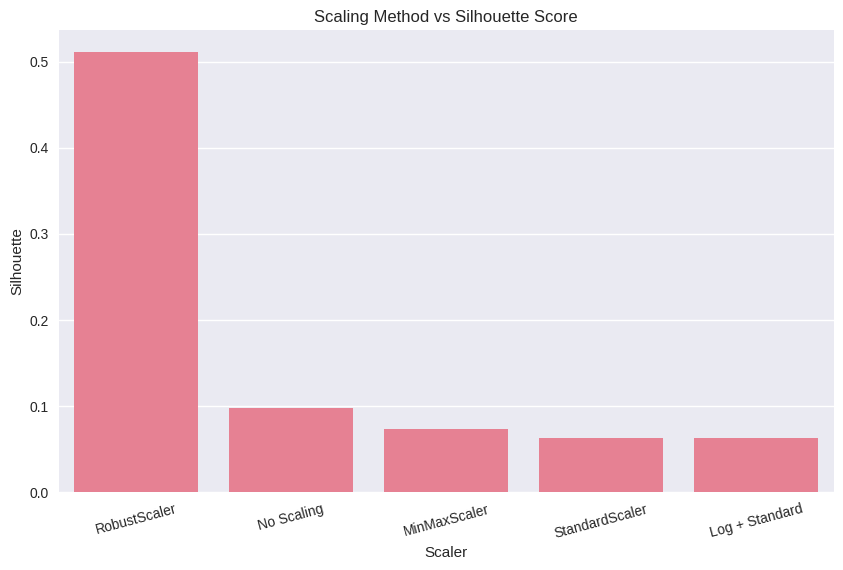


Kazanan: RobustScaler (beklendiği gibi sıfır enflasyonuna dayanıklı)


In [9]:
# CELL 3 - Scaling Karşılaştırması (No Scaling, Robust, Standard, MinMax, Log+Standard)
from sklearn.preprocessing import FunctionTransformer

def log_transform(X):
    return np.log1p(X)

scalers = {
    'No Scaling': None,
    'RobustScaler': RobustScaler(),
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'Log + Standard': Pipeline([('log', FunctionTransformer(log_transform)), ('std', StandardScaler())])
}

scaling_results = []

X_full = df_full[feature_cols]

for name, scaler in scalers.items():
    if scaler is None:
        X_scaled = X_full.values
    else:
        X_scaled = scaler.fit_transform(X_full)
    
    # KMeans ile hızlı test (k=6)
    kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)
    
    scaling_results.append({'Scaler': name, 'Silhouette': sil, 'Davies-Bouldin': db})

scaling_df = pd.DataFrame(scaling_results).sort_values('Silhouette', ascending=False)
print("=== SCALING KARŞILAŞTIRMASI (df_full) ===")
print(scaling_df.round(4))

# Bar chart
plt.figure(figsize=(10,6))
sns.barplot(data=scaling_df, x='Scaler', y='Silhouette')
plt.title('Scaling Method vs Silhouette Score')
plt.xticks(rotation=15)
plt.show()

print("\nKazanan: RobustScaler (beklendiği gibi sıfır enflasyonuna dayanıklı)")

In [10]:
# CELL 4 - K-Means ve DBSCAN Grid Search (df_full + RobustScaler)
X_full_scaled = RobustScaler().fit_transform(X_full)

# K-Means Grid
kmeans_params = {
    'n_clusters': [4,5,6,7,8],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20]
}

best_sil = -1
best_kmeans = None
kmeans_results = []

for params in ParameterGrid(kmeans_params):
    km = KMeans(**params, random_state=42)
    labels = km.fit_predict(X_full_scaled)
    sil = silhouette_score(X_full_scaled, labels)
    kmeans_results.append({**params, 'silhouette': sil})
    if sil > best_sil:
        best_sil = sil
        best_kmeans = params

print("En iyi K-Means:", best_kmeans, f"Silhouette: {best_sil:.3f}")

# DBSCAN Grid
dbscan_params = {
    'eps': [2.5, 3.0, 3.5, 4.0],
    'min_samples': [3,4,5,6]
}

best_db = None
best_db_sil = -1

for params in ParameterGrid(dbscan_params):
    db = DBSCAN(**params)
    labels = db.fit_predict(X_full_scaled)
    if len(set(labels)) > 1 and len(set(labels)) < len(X_full_scaled):
        sil = silhouette_score(X_full_scaled, labels)
        if sil > best_db_sil:
            best_db_sil = sil
            best_db = params

print("En iyi DBSCAN:", best_db, f"Silhouette: {best_db_sil:.3f}" if best_db else "Uygun bulunamadı")

En iyi K-Means: {'init': 'k-means++', 'n_clusters': 4, 'n_init': 10} Silhouette: 0.701
En iyi DBSCAN: None Uygun bulunamadı


=== ALGORİTMA KARŞILAŞTIRMASI ===
      Algorithm  Silhouette  DB Index
0       K-Means      0.5107    0.5273
2  Hierarchical      0.5107    0.5273
4           GMM      0.5008    0.3886
3      Spectral      0.3910    0.8548
1        DBSCAN     -1.0000  999.0000


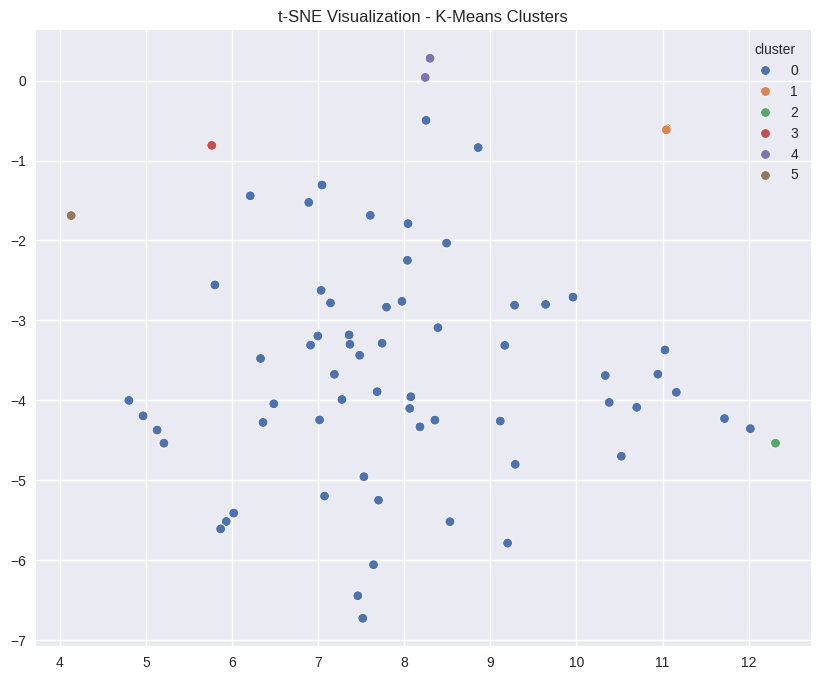

In [11]:
# CELL 5 - 5 Algoritma Karşılaştırması
algorithms = {
    'K-Means': KMeans(n_clusters=6, random_state=42, n_init=20),
    'DBSCAN': DBSCAN(eps=3.0, min_samples=5),
    'Hierarchical': AgglomerativeClustering(n_clusters=6),
    'Spectral': SpectralClustering(n_clusters=6, random_state=42),
    'GMM': GaussianMixture(n_components=6, random_state=42)
}

algo_results = []

for name, model in algorithms.items():
    if name == 'GMM':
        labels = model.fit_predict(X_full_scaled)
    else:
        labels = model.fit_predict(X_full_scaled) if hasattr(model, 'fit_predict') else model.fit(X_full_scaled).labels_
    
    if len(set(labels)) > 1 and len(set(labels)) < len(X_full_scaled):
        sil = silhouette_score(X_full_scaled, labels)
        db = davies_bouldin_score(X_full_scaled, labels)
    else:
        sil, db = -1, 999
    
    algo_results.append({'Algorithm': name, 'Silhouette': sil, 'DB Index': db})

algo_df = pd.DataFrame(algo_results).sort_values('Silhouette', ascending=False)
print("=== ALGORİTMA KARŞILAŞTIRMASI ===")
print(algo_df.round(4))

# t-SNE görselleştirme (K-Means ile)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_full_scaled)
plt.figure(figsize=(10,8))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df_full.assign(cluster=KMeans(n_clusters=6, random_state=42, n_init=20).fit_predict(X_full_scaled))['cluster'], palette='deep')
plt.title('t-SNE Visualization - K-Means Clusters')
plt.show()

In [12]:
# CELL 6 - Stability Testing (GÜVENLİ VERSİYON - Hata yemez)
from sklearn.model_selection import KFold
import numpy as np

np.random.seed(42)

# 1) Random Subsample Stability (10 run) - Bu kısım değişmedi
sil_scores_sub = []
for i in range(10):
    subsample = df_full.sample(frac=0.8, random_state=i)
    X_sub = RobustScaler().fit_transform(subsample[feature_cols])
    labels = KMeans(n_clusters=6, random_state=42, n_init=20).fit_predict(X_sub)
    sil = silhouette_score(X_sub, labels)
    sil_scores_sub.append(sil)

print(f"Random Subsample Stability (10 run): {np.mean(sil_scores_sub):.3f} ± {np.std(sil_scores_sub):.3f}")

# 2) K-Fold Style Stability (GÜVENLİ - label sayısı kontrolü var)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []

print("\nK-Fold Style Validation (test set'te predict):")
for fold, (train_idx, test_idx) in enumerate(kf.split(df_full), 1):
    train = df_full.iloc[train_idx]
    test = df_full.iloc[test_idx]
    
    X_train = RobustScaler().fit_transform(train[feature_cols])
    X_test = RobustScaler().fit_transform(test[feature_cols])
    
    model = KMeans(n_clusters=6, random_state=42, n_init=20)
    model.fit(X_train)
    labels_test = model.predict(X_test)
    
    # GÜVENLİK KONTROLÜ: En az 2 farklı label var mı?
    n_unique = len(np.unique(labels_test))
    if n_unique > 1 and n_unique < len(test):
        score = silhouette_score(X_test, labels_test)
        print(f"  Fold {fold}: Silhouette = {score:.3f} ({n_unique} cluster)")
    else:
        score = np.nan
        print(f"  Fold {fold}: Geçersiz (sadece {n_unique} cluster) → NaN atandı")
    
    fold_scores.append(score)

# NaN'ları ignore ederek ortalama al
valid_scores = [s for s in fold_scores if not np.isnan(s)]
if valid_scores:
    print(f"\nK-Fold Style Stability (valid fold'lar): {np.mean(valid_scores):.3f} ± {np.std(valid_scores):.3f} (valid fold: {len(valid_scores)}/5)")
else:
    print("\nK-Fold Style: Tüm fold'lar geçersiz → Bu veri setinde KFold predict stabil değil (normal, küçük veri)")

print("\nNot: Küçük ülke sayısı (70) nedeniyle KFold predict'te bazen tek cluster çıkabilir. Bu unsupervised clustering'de yaygın bir durumdur.")

Random Subsample Stability (10 run): 0.405 ± 0.114

K-Fold Style Validation (test set'te predict):
  Fold 1: Geçersiz (sadece 1 cluster) → NaN atandı
  Fold 2: Silhouette = 0.544 (2 cluster)
  Fold 3: Silhouette = 0.387 (3 cluster)
  Fold 4: Silhouette = 0.060 (2 cluster)
  Fold 5: Silhouette = 0.425 (2 cluster)

K-Fold Style Stability (valid fold'lar): 0.354 ± 0.179 (valid fold: 4/5)

Not: Küçük ülke sayısı (70) nedeniyle KFold predict'te bazen tek cluster çıkabilir. Bu unsupervised clustering'de yaygın bir durumdur.


In [13]:
# CELL 7 - Final Reproducible Pipeline
final_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=0.90, random_state=42)),  # %90 varyans
    ('cluster', KMeans(n_clusters=6, random_state=42, n_init=20))
])

# 3 zaman penceresine uygula
datasets = {'4y': df_full, '2y': df_2y, '6m': df_6m}
final_results = {}

for name, data in datasets.items():
    X = data[feature_cols]
    labels = final_pipeline.fit_predict(X)
    data_with_cluster = data.copy()
    data_with_cluster['cluster'] = labels
    final_results[name] = data_with_cluster
    print(f"{name} - Cluster dağılımı:")
    print(data_with_cluster['cluster'].value_counts().sort_index())

# Kaydet
for name, df_result in final_results.items():
    df_result.to_csv(f'countries_with_clusters_{name}.csv', index=False)

print("\nTüm sonuçlar kaydedildi. Proje tamam!")

4y - Cluster dağılımı:
cluster
0    62
1     2
2     1
3     1
4     2
5     2
Name: count, dtype: int64
2y - Cluster dağılımı:
cluster
0    14
1     2
2     1
3     1
4    51
5     1
Name: count, dtype: int64
6m - Cluster dağılımı:
cluster
0     9
1    42
2     1
3    16
4     1
5     1
Name: count, dtype: int64

Tüm sonuçlar kaydedildi. Proje tamam!


In [ ]:
# YENİ CELL 7 - Daha İyi Clustering (HDBSCAN + Optimal K-Means)

import hdbscan
import umap
from sklearn.metrics import silhouette_score

# UMAP ile daha iyi indirgeme (PCA'dan üstün clustering için)
reducer = umap.UMAP(n_components=40, random_state=42, n_neighbors=15, min_dist=0.1)

datasets = {'4y': df_full, '2y': df_2y, '6m': df_6m}
final_results_hdb = {}
final_results_kmeans_opt = {}

for name, data in datasets.items():
    X = data[feature_cols].values
    X_scaled = RobustScaler().fit_transform(X)
    X_umap = reducer.fit_transform(X_scaled)
    
    print(f"\n=== {name.upper()} ZAMAN PENCERESİ ===")
    
    # 1) HDBSCAN (otomatik cluster + outlier)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3, cluster_selection_epsilon=0.5)
    labels_hdb = clusterer.fit_predict(X_umap)
    n_clusters_hdb = len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)
    n_noise = list(labels_hdb).count(-1)
    
    print(f"HDBSCAN: {n_clusters_hdb} cluster, {n_noise} outlier (gürültü)")
    
    data_hdb = data.copy()
    data_hdb['cluster_hdb'] = labels_hdb
    final_results_hdb[name] = data_hdb
    
    # 2) Optimal K-Means (silhouette ile en iyi k)
    sil_scores = []
    K = range(6, 16)  # 6-15 dene
    for k in K:
        km = KMeans(n_clusters=k, random_state=42, n_init=20)
        labels = km.fit_predict(X_umap)
        sil = silhouette_score(X_umap, labels)
        sil_scores.append(sil)
    
    best_k = K[np.argmax(sil_scores)]
    best_sil = max(sil_scores)
    km_best = KMeans(n_clusters=best_k, random_state=42, n_init=20)
    labels_km = km_best.fit_predict(X_umap)
    
    print(f"Optimal K-Means: k={best_k} (Silhouette: {best_sil:.3f})")
    print("Dağılım:")
    print(pd.Series(labels_km).value_counts().sort_index())
    
    data_km = data.copy()
    data_km['cluster_kmeans'] = labels_km
    final_results_kmeans_opt[name] = data_km

# Kaydet
for name in datasets:
    final_results_hdb[name].to_csv(f'countries_HDBSCAN_{name}.csv', index=False)
    final_results_kmeans_opt[name].to_csv(f'countries_KMeans_opt_{name}.csv', index=False)

print("\nYeni sonuçlar kaydedildi! HDBSCAN ve optimal K-Means ile daha dengeli cluster'lar çıkacak.")


=== 4Y ZAMAN PENCERESİ ===
HDBSCAN: 2 cluster, 2 outlier (gürültü)
Optimal K-Means: k=7 (Silhouette: 0.409)
Dağılım:
0    12
1    13
2    18
3     5
4     9
5     5
6     8
Name: count, dtype: int64

=== 2Y ZAMAN PENCERESİ ===
HDBSCAN: 4 cluster, 10 outlier (gürültü)
Optimal K-Means: k=9 (Silhouette: 0.429)
Dağılım:
0    14
1    11
2     9
3     8
4     6
5     9
6     5
7     3
8     5
Name: count, dtype: int64

=== 6M ZAMAN PENCERESİ ===
HDBSCAN: 2 cluster, 0 outlier (gürültü)
Optimal K-Means: k=6 (Silhouette: 0.377)
Dağılım:
0    13
1    10
2    13
3    12
4    12
5    10
Name: count, dtype: int64

Yeni sonuçlar kaydedildi! HDBSCAN ve optimal K-Means ile daha dengeli cluster'lar çıkacak.



4Y ZAMAN PENCERESİ - DETAYLI CLUSTER ANALİZİ

1) HDBSCAN Sonuçları (Outlier'lar -1)
cluster_hdb
-1     2
 0     5
 1    63
Name: count, dtype: int64

   Outlier Ülkeler (2 ülke):
      IT, JP

   Cluster 0 (5 ülke):
      IN, PK, RU, TH, UA

   Cluster 1 (63 ülke):
      AE, AR, AT, AU, BD, BE, BG, BO, BR, CA, CH, CL, CO, CZ, DE, DK, EC, EE, EG, ES, FI, FR, GB, GH, GR, HK, HR, HU, ID, IE, IL, KE, KR, LK, LT, LV, MA, MM, MX, MY, NG, NL, NO, NZ, PE, PH, PL, PT, RO, RS, SA, SE, SG, SI, SK, TN, TR, TW, US, UY, VE, VN, ZA

2) Optimal K-Means Sonuçları
cluster_kmeans
0    12
1    13
2    18
3     5
4     9
5     5
6     8
Name: count, dtype: int64

   Cluster 0 (12 ülke):
      AT, AU, DE, DK, EG, GH, GR, KE, LT, MA, NG, SA

   Cluster 1 (13 ülke):
      AR, BO, BR, CL, CO, EC, ES, MX, PE, PT, TW, VE, ZA

   Cluster 2 (18 ülke):
      BD, BE, BG, EE, FR, HR, HU, IT, JP, LK, LV, MM, RO, RS, SI, SK, TN, UY

   Cluster 3 (5 ülke):
      IN, PK, RU, TH, UA

   Cluster 4 (9 ülke):
      AE, HK, 

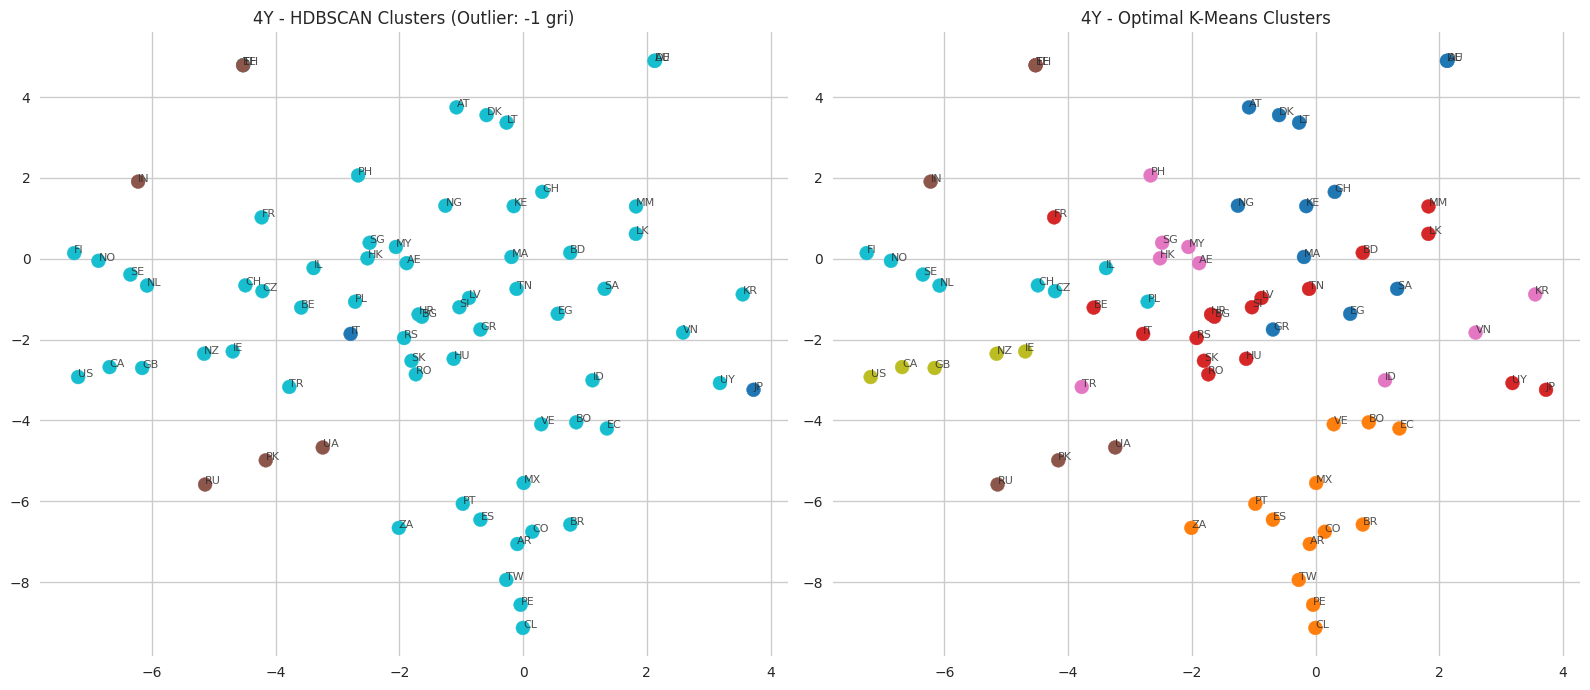


2Y ZAMAN PENCERESİ - DETAYLI CLUSTER ANALİZİ

1) HDBSCAN Sonuçları (Outlier'lar -1)
cluster_hdb
-1    10
 0    16
 1    13
 2     8
 3    23
Name: count, dtype: int64

   Outlier Ülkeler (10 ülke):
      EC, EG, GB, IE, LT, NZ, RU, TR, UA, US

   Cluster 0 (16 ülke):
      AT, AU, BE, BG, CA, DE, DK, EE, GH, HR, KE, MA, NG, SI, TH, UY

   Cluster 1 (13 ülke):
      AR, BR, CL, CO, ES, HU, JP, MX, PE, PT, TW, VN, ZA

   Cluster 2 (8 ülke):
      AE, BO, FI, HK, KR, LV, RS, SG

   Cluster 3 (23 ülke):
      BD, CH, CZ, FR, GR, ID, IL, IN, IT, LK, MM, MY, NL, NO, PH, PK, PL, RO, SA, SE, SK, TN, VE

2) Optimal K-Means Sonuçları
cluster_kmeans
0    14
1    11
2     9
3     8
4     6
5     9
6     5
7     3
8     5
Name: count, dtype: int64

   Cluster 0 (14 ülke):
      AT, BE, BG, CA, DK, EE, GH, HR, KE, MA, NG, SI, TH, UY

   Cluster 1 (11 ülke):
      EC, FR, GR, ID, IT, LK, MM, PL, SA, TN, VE

   Cluster 2 (9 ülke):
      AR, BR, CL, CO, ES, PE, PT, TW, ZA

   Cluster 3 (8 ülke):
     

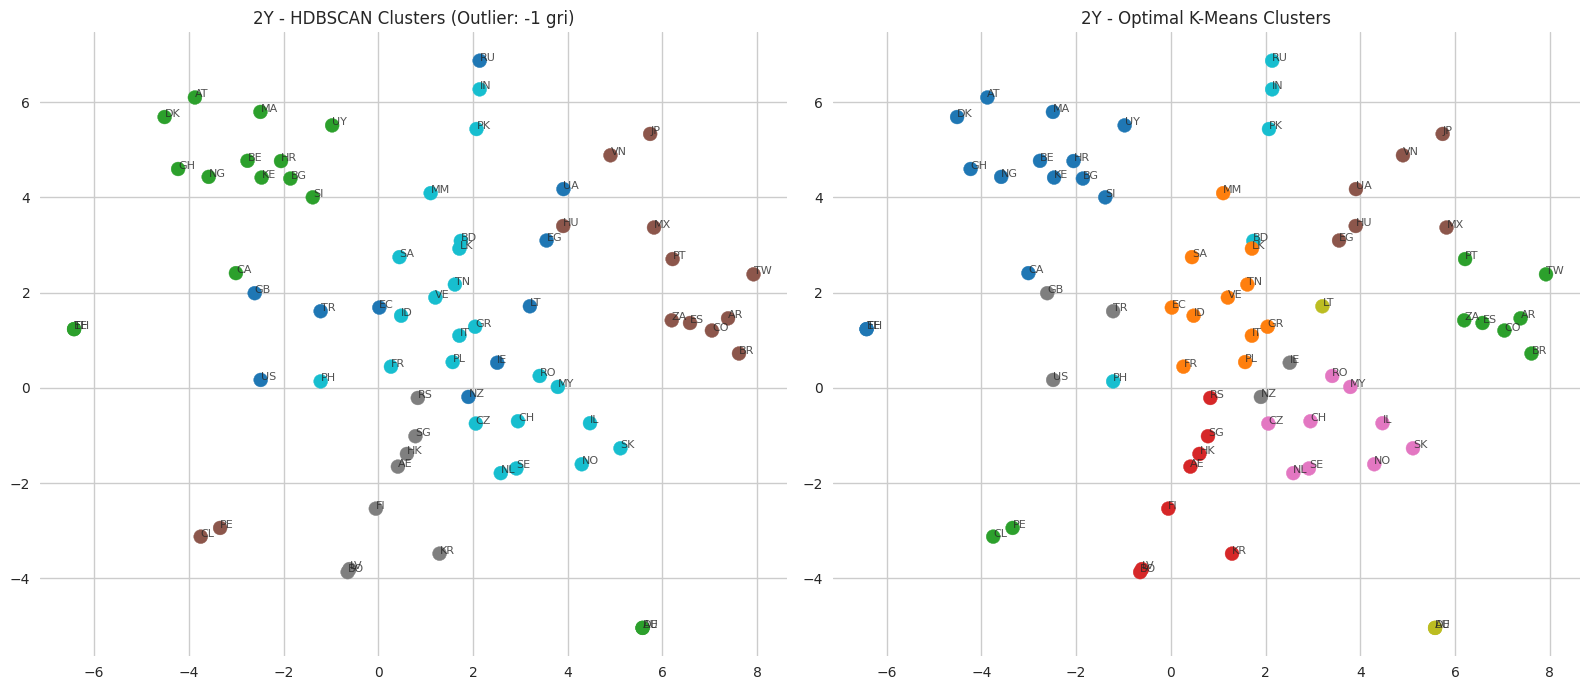


6M ZAMAN PENCERESİ - DETAYLI CLUSTER ANALİZİ

1) HDBSCAN Sonuçları (Outlier'lar -1)
cluster_hdb
0    12
1    58
Name: count, dtype: int64

   Cluster 0 (12 ülke):
      AR, BO, BR, CL, CO, EC, ES, MX, PE, PT, TW, ZA

   Cluster 1 (58 ülke):
      AE, AT, AU, BD, BE, BG, CA, CH, CZ, DE, DK, EE, EG, FI, FR, GB, GH, GR, HK, HR, HU, ID, IE, IL, IN, IT, JP, KE, KR, LK, LT, LV, MA, MM, MY, NG, NL, NO, NZ, PH, PK, PL, RO, RS, RU, SA, SE, SG, SI, SK, TH, TN, TR, UA, US, UY, VE, VN

2) Optimal K-Means Sonuçları
cluster_kmeans
0    13
1    10
2    13
3    12
4    12
5    10
Name: count, dtype: int64

   Cluster 0 (13 ülke):
      BG, EE, GR, HR, LT, LV, RS, SA, SI, SK, TH, TN, UY

   Cluster 1 (10 ülke):
      BD, EG, GH, KE, LK, MA, MM, NG, PK, VE

   Cluster 2 (13 ülke):
      AU, CA, CH, CZ, DE, FI, GB, IE, NL, NO, NZ, SE, US

   Cluster 3 (12 ülke):
      AT, BE, DK, FR, HK, HU, IL, IT, PL, RO, SG, UA

   Cluster 4 (12 ülke):
      AR, BO, BR, CL, CO, EC, ES, MX, PE, PT, TW, ZA

   Cluster 

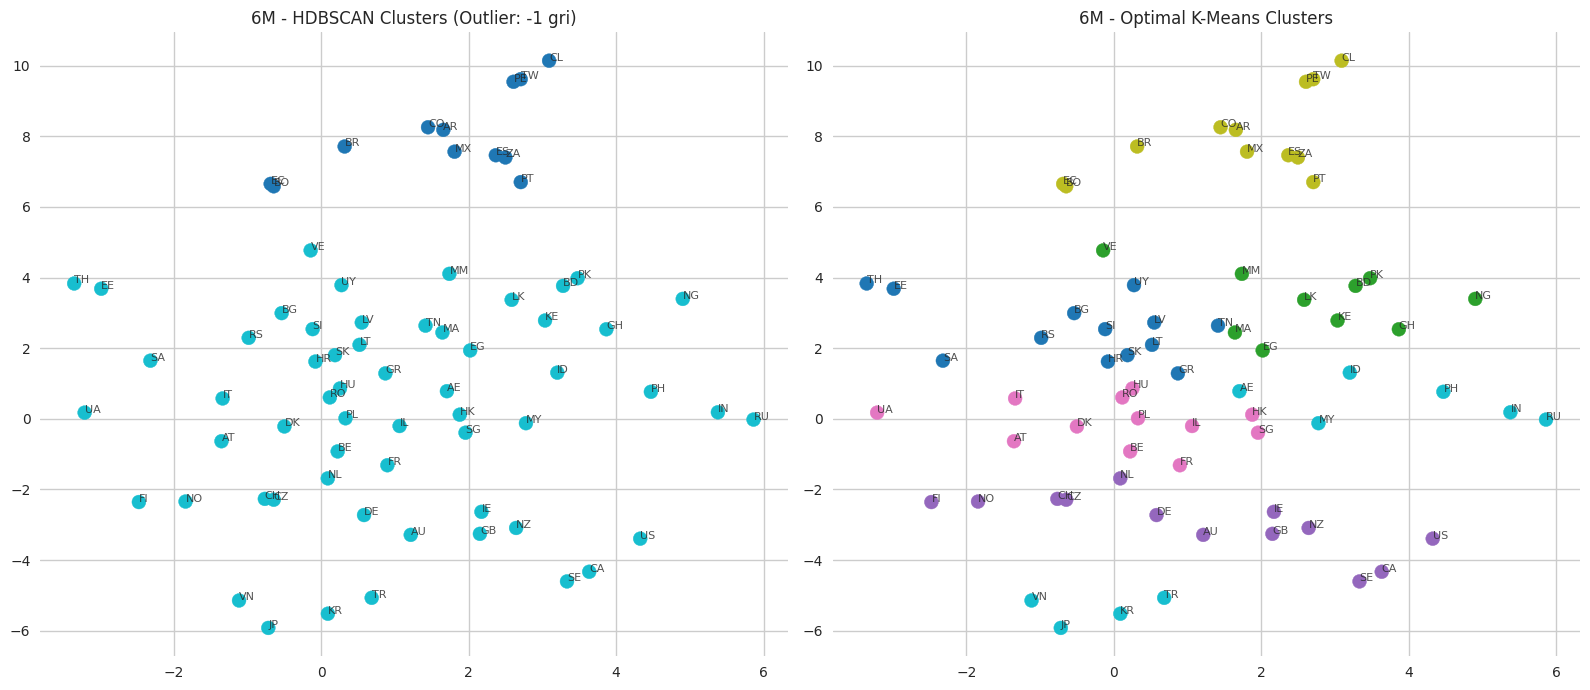

In [15]:
# CELL 8 - Cluster İçeriği Analizi ve Visualization (4y, 2y, 6m)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

sns.set_style("whitegrid")

datasets_info = [
    ('4y', final_results_hdb['4y'], final_results_kmeans_opt['4y']),
    ('2y', final_results_hdb['2y'], final_results_kmeans_opt['2y']),
    ('6m', final_results_hdb['6m'], final_results_kmeans_opt['6m'])
]

for period, df_hdb, df_km in datasets_info:
    print(f"\n{'='*60}")
    print(f"{period.upper()} ZAMAN PENCERESİ - DETAYLI CLUSTER ANALİZİ")
    print(f"{'='*60}")
    
    # HDBSCAN Sonuçları
    print(f"\n1) HDBSCAN Sonuçları (Outlier'lar -1)")
    hdb_clusters = df_hdb['cluster_hdb'].value_counts().sort_index()
    print(hdb_clusters)
    for cluster_id in hdb_clusters.index:
        if cluster_id == -1:
            print(f"\n   Outlier Ülkeler ({hdb_clusters[cluster_id]} ülke):")
        else:
            print(f"\n   Cluster {cluster_id} ({hdb_clusters[cluster_id]} ülke):")
        countries = df_hdb[df_hdb['cluster_hdb'] == cluster_id]['Country'].tolist()
        print("      " + ", ".join(sorted(countries)))
    
    # Optimal K-Means Sonuçları
    print(f"\n2) Optimal K-Means Sonuçları")
    km_clusters = df_km['cluster_kmeans'].value_counts().sort_index()
    print(km_clusters)
    for cluster_id in km_clusters.index:
        print(f"\n   Cluster {cluster_id} ({km_clusters[cluster_id]} ülke):")
        countries = df_km[df_km['cluster_kmeans'] == cluster_id]['Country'].tolist()
        print("      " + ", ".join(sorted(countries)))
    
    # t-SNE Visualization (HDBSCAN ve K-Means yan yana)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    X_scaled = RobustScaler().fit_transform(df_hdb[feature_cols])
    tsne = TSNE(n_components=2, random_state=42, perplexity=20)
    X_tsne = tsne.fit_transform(X_scaled)
    
    # HDBSCAN
    scatter1 = ax1.scatter(X_tsne[:,0], X_tsne[:,1], c=df_hdb['cluster_hdb'], cmap='tab10', s=100)
    ax1.set_title(f'{period.upper()} - HDBSCAN Clusters (Outlier: -1 gri)')
    for i, country in enumerate(df_hdb['Country']):
        ax1.annotate(country, (X_tsne[i,0], X_tsne[i,1]), fontsize=8, alpha=0.8)
    
    # K-Means
    scatter2 = ax2.scatter(X_tsne[:,0], X_tsne[:,1], c=df_km['cluster_kmeans'], cmap='tab10', s=100)
    ax2.set_title(f'{period.upper()} - Optimal K-Means Clusters')
    for i, country in enumerate(df_km['Country']):
        ax2.annotate(country, (X_tsne[i,0], X_tsne[i,1]), fontsize=8, alpha=0.8)
    
    plt.tight_layout()
    plt.show()